Models and data loaded successfully!
Best model type: LogisticRegression
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75       390

    accuracy                           0.60       390
   macro avg       0.50      0.30      0.37       390
weighted avg       1.00      0.60      0.75       390



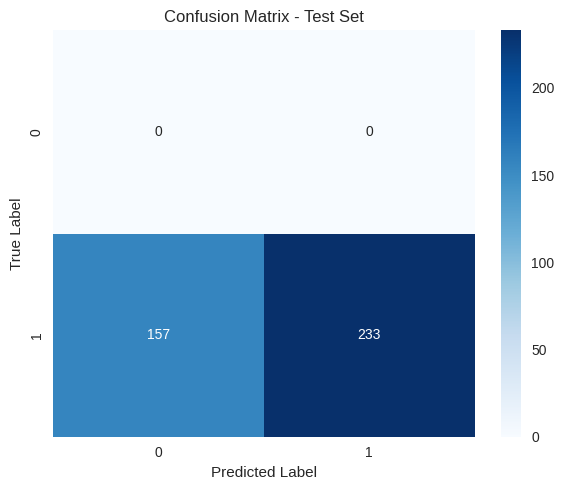

Test Case Results:
   Case    GDP  Unemployment  Youth %  Internet %  Polity  Prev Events  \
0     1   5000          15.0     35.0        40.0      -5            1   
1     2  40000           4.0     18.0        85.0       8            0   
2     3  11372           3.7     24.8        89.6       8            0   

   Risk Score Prediction  
0       0.610  High Risk  
1       0.693  High Risk  
2       0.571  High Risk  


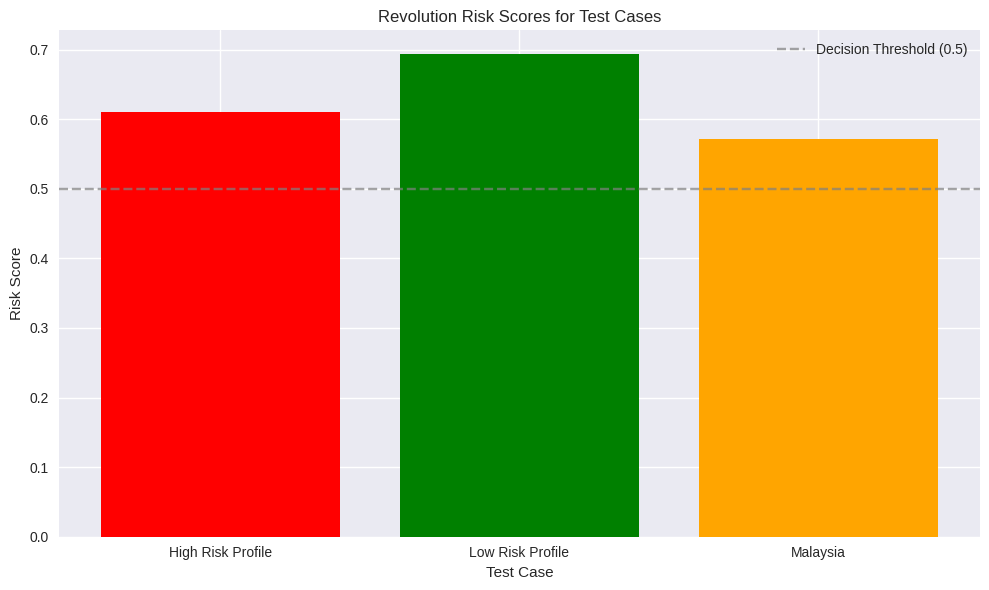

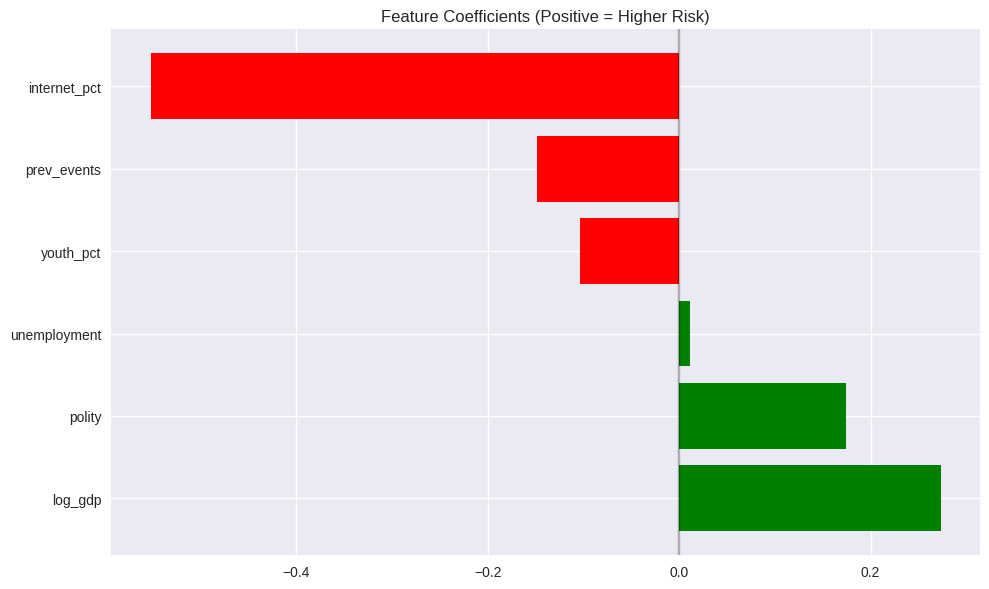

Number of misclassified examples: 157

Misclassified examples:
    log_gdp  unemployment  youth_pct  internet_pct    polity  prev_events  \
0 -0.002831      0.449307   0.182657      0.391915  0.368831     0.209102   
1  0.004968      0.290417   0.236360      0.435718  0.393553     0.209102   
2  0.005610      0.359618   0.230993      0.376983  0.412849     0.209102   
3  0.003635      0.202490   0.251229      0.387679  0.412919     0.209102   
4  0.003165      0.392261   0.233951      0.399663  0.393633     0.209102   
5  0.007571      0.329809   0.238158      0.441088  0.379404     0.209102   
6  0.017702      0.364917   0.291313      0.412909  0.390121     0.209102   
7  0.006084      0.144836   0.271681      0.403205  0.364329     0.209102   
8  0.008450      0.308927   0.270651      0.404990  0.383834     0.209102   
9  0.003349      0.144639   0.258556      0.416322  0.409766     0.209102   

   true_label  predicted_label  probability  
0           1                0     0.467722

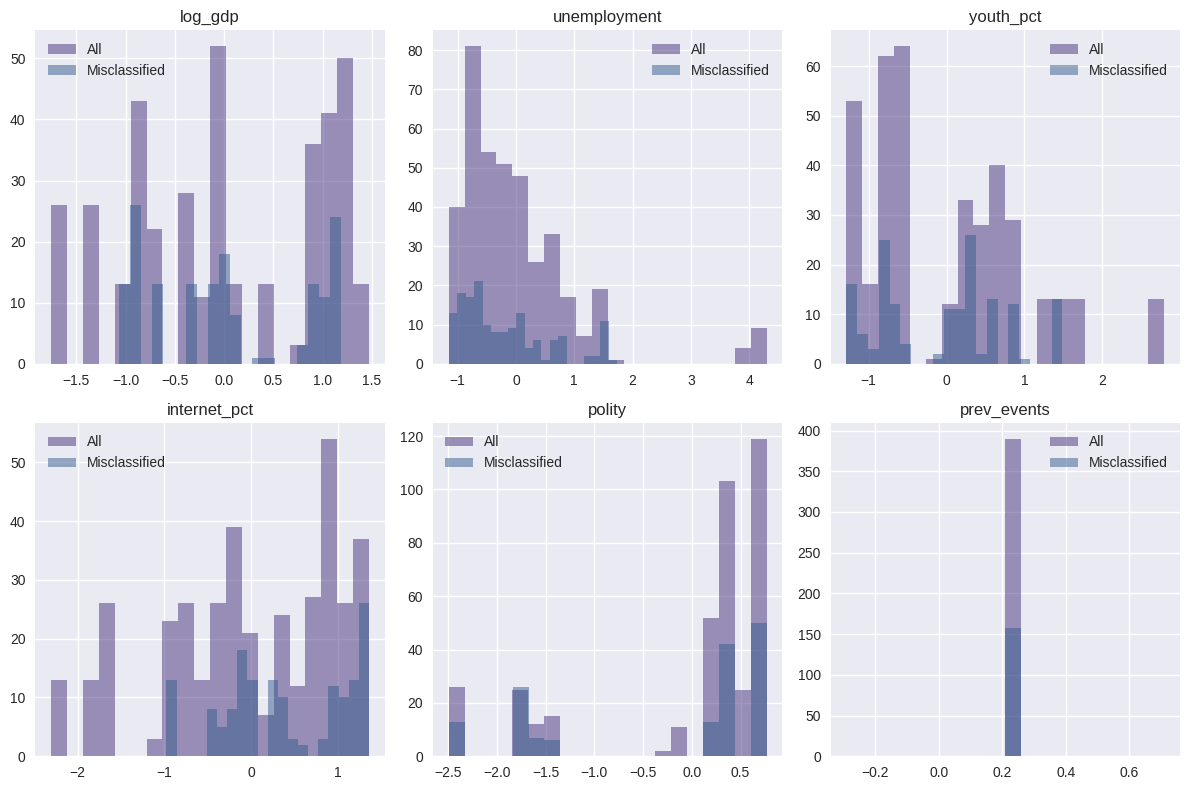

Test results saved to data/test_case_results.csv

Model testing completed!


In [1]:
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3
#     language: python
#     name: python3
# ---

# # Revolution Risk Predictor - Model Testing
# 
# This notebook tests the trained model with new inputs and provides model interpretation.

# ## Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

# ## Load Models and Data

# Load the best model
best_model = joblib.load('../models/best_model.joblib')
scaler = joblib.load('../models/scaler.joblib')

# Load test data
X_test = pd.read_csv('../data/X_test.csv')
y_test = pd.read_csv('../data/y_test.csv').iloc[:, 0]  # FIXED: Get first column as Series

print("Models and data loaded successfully!")
print(f"Best model type: {type(best_model).__name__}")

# ## Model Performance on Test Set

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ## Test with Custom Inputs

# Define feature names
feature_names = ['log_gdp', 'unemployment', 'youth_pct', 'internet_pct', 'polity', 'prev_events']

# Create test cases
test_cases = [
    # High risk case (low GDP, high unemployment, low polity, etc.)
    {
        'gdp': 5000,  # Low GDP
        'unemployment': 15.0,  # High unemployment
        'youth_pct': 35.0,  # High youth percentage
        'internet_pct': 40.0,  # Low internet penetration
        'polity': -5,  # Autocratic regime
        'prev_events': 1  # Previous events
    },
    # Low risk case (high GDP, low unemployment, high polity, etc.)
    {
        'gdp': 40000,  # High GDP
        'unemployment': 4.0,  # Low unemployment
        'youth_pct': 18.0,  # Moderate youth percentage
        'internet_pct': 85.0,  # High internet penetration
        'polity': 8,  # Democratic regime
        'prev_events': 0  # No previous events
    },
    # Malaysia case
    {
        'gdp': 11372,  # Malaysia GDP
        'unemployment': 3.7,  # Malaysia unemployment
        'youth_pct': 24.8,  # Malaysia youth percentage
        'internet_pct': 89.6,  # Malaysia internet penetration
        'polity': 8,  # Malaysia polity score
        'prev_events': 0  # No previous events
    }
]

# Process and predict for each test case
results = []
for i, case in enumerate(test_cases):
    # Create feature vector
    features = np.array([
        np.log1p(case['gdp']),  # log_gdp
        case['unemployment'],
        case['youth_pct'],
        case['internet_pct'],
        case['polity'],
        case['prev_events']
    ]).reshape(1, -1)
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    probability = best_model.predict_proba(features_scaled)[0, 1] if hasattr(best_model, "predict_proba") else best_model.decision_function(features_scaled)[0]
    prediction = best_model.predict(features_scaled)[0]
    
    # Store results
    results.append({
        'Case': i + 1,
        'GDP': case['gdp'],
        'Unemployment': case['unemployment'],
        'Youth %': case['youth_pct'],
        'Internet %': case['internet_pct'],
        'Polity': case['polity'],
        'Prev Events': case['prev_events'],
        'Risk Score': probability,
        'Prediction': 'High Risk' if prediction == 1 else 'Low Risk'
    })

# Display results
results_df = pd.DataFrame(results)
print("Test Case Results:")
print(results_df.round(3))

# Visualize risk scores
plt.figure(figsize=(10, 6))
plt.bar(range(len(results_df)), results_df['Risk Score'], color=['red', 'green', 'orange'])
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Decision Threshold (0.5)')
plt.title('Revolution Risk Scores for Test Cases')
plt.xlabel('Test Case')
plt.ylabel('Risk Score')
plt.xticks(range(len(results_df)), ['High Risk Profile', 'Low Risk Profile', 'Malaysia'])
plt.legend()
plt.tight_layout()
plt.show()

# ## Model Interpretation

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    # Tree-based model
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
elif hasattr(best_model, 'coef_'):
    # Linear model
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': best_model.coef_[0]
    }).sort_values('coefficient', ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if coef < 0 else 'green' for coef in coefficients['coefficient']]
    plt.barh(coefficients['feature'], coefficients['coefficient'], color=colors)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Feature Coefficients (Positive = Higher Risk)')
    plt.tight_layout()
    plt.show()

# ## Error Analysis

# Get misclassified examples
misclassified = X_test[y_test != y_pred].copy()
misclassified['true_label'] = y_test[y_test != y_pred]
misclassified['predicted_label'] = y_pred[y_test != y_pred]
misclassified['probability'] = y_proba[y_test != y_pred]

print(f"Number of misclassified examples: {len(misclassified)}")
if len(misclassified) > 0:
    print("\nMisclassified examples:")
    print(misclassified.head(10))
    
    # Analyze patterns in misclassifications
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        plt.hist(X_test[feature], alpha=0.5, label='All', bins=20)
        plt.hist(misclassified[feature], alpha=0.5, label='Misclassified', bins=20)
        plt.title(feature)
        plt.legend()
    plt.tight_layout()
    plt.show()

# ## Save Test Results

results_df.to_csv('../data/test_case_results.csv', index=False)
print("Test results saved to data/test_case_results.csv")

print("\nModel testing completed!")